In [ ]:
# Imports #
import numpy as np
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor, AutoModelForSeq2SeqLM, AutoTokenizer, T5Tokenizer
import torch
import os
import pandas as pd
from datasets import load_dataset
import torch.nn.functional as F
from tqdm import tqdm

# Project imports #
import sys
sys.path.append('./Mind2Web/src')

import utils
from mind2web.dataloader import build_split_datasets
from utils import CACHE_DIR
from utils import log_response

In [2]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl", cache_dir=CACHE_DIR)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "osunlp/MindAct_ActionPrediction_flan-t5-xl" #"Qwen/Qwen-3.5-VL-Base"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir=CACHE_DIR)
model = model.to(device)
model.eval();


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
utils.reload('mind2web.dataloader')

idx_split_map = {0:"test_task", 1:"test_domain", 2:"test_website"}
split_idx_map = {v:k for k,v in idx_split_map.items()}

cal_dict, test_dict = build_split_datasets(idx_split_map.values(),
                                            tokenizer,
                                              seed=42,
                                              frac=0.2,
                                              cache_dir=CACHE_DIR)


mind2web.dataloader- reloaded


Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
# utils.reload()
choices_to_token_ids = cal_dict['test_domain'].choices_token_ids_mapping()
max_new_tokens = 50 #1?

def run_evaluation(data_sets:dict, max_iter=None):
    outputs = []
    for ds_split, ds in data_sets.items():
        split_idx = split_idx_map[ds_split]
        relative_idx = 0
        for i, item in enumerate(tqdm(ds, desc="Generating calibration set")):
            if max_iter is not None and i > max_iter:
                break
            model_input = llm_utils.tensorize_item(item, device)

            with torch.no_grad():
                    out = model.generate(
                        **model_input,
                        eos_token_id=model.config.eos_token_id,
                        max_new_tokens=max_new_tokens,
                        return_dict_in_generate=True,
                        output_scores=True,
                    )

            decoded = tokenizer.decode(out["sequences"][0], skip_special_tokens=True)
            pred_label, pred_action, pred_value = utils.llm.parse_output(decoded)
            labels_tokens = item.get("labels")
            
            # Calculate choice probabilities
            logits = out["scores"][0][0]
            all_probs = F.softmax(logits, dim=-1)
            probs = all_probs[list(choices_to_token_ids.values())]
            choices_probs = dict(zip(choices_to_token_ids.keys(), probs.cpu().tolist()))
            labels = item.get("labels").strip()
            outputs.append(
                    [
                        i,
                        ds.data[relative_idx]["annotation_id"],
                        ds.data[relative_idx]["action_uid"],
                        pred_label, pred_action, pred_value,
                        labels.split('.')[0],
                        labels, 
                        choices_probs,
                        choices_probs.get(pred_label, 0),
                        split_idx,
                        labels_tokens

                    ]    
                )
            log_response(ds.data[relative_idx]["annotation_id"], ds.data[relative_idx]["action_uid"], decoded)
            relative_idx += 1
        

    cols = ["index", "annotation_id", "action_uid", "pred_label", "pred_action", "pred_value",
             "label",'label_text', "choices_probs", "prob", "test_split", "labels_tokens"]
    results_df = pd.DataFrame(outputs, columns=cols)
    return results_df
# cal_df = run_evaluation({0: cal_dict[idx_split_map[1]]}, max_iter=1)

# 15 seconds per iteration ! NOT GOOD

In [7]:
# cal_df = run_evaluation(cal_dict, max_iter=None)
# if len(cal_df):
    # cal_df.to_pickle("cal_results.pkl")
cal_df = pd.read_pickle("cal_results.pkl")
cal_df.head()

,index,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,labels_tokens
0,0,0572899e-7c07-4a2f-a77b-bba4f432a7ad,7194e8bf-6cf3-4f36-a37f-70fd065c4aac,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.00027643711655400693, 'B': 0.999675869...",0.999676,0,B.\nAction: CLICK\n
1,1,0572899e-7c07-4a2f-a77b-bba4f432a7ad,aa34483b-ad90-4054-b38b-d29157a1c517,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.002066487679257989, 'B': 0.99775898456...",0.997759,0,B.\nAction: CLICK\n
2,2,0572899e-7c07-4a2f-a77b-bba4f432a7ad,49b0e49e-deab-4400-987a-4cfd6ba09a84,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.000798287452198565, 'B': 0.99910348653...",0.999103,0,B.\nAction: CLICK\n
3,3,0572899e-7c07-4a2f-a77b-bba4f432a7ad,aa40812d-f178-4d28-b6de-6ec9ca1b2758,B,TYPE,SFTBAO,B,B.\nAction: TYPE\nValue: SFTBAO,"{'A': 0.0004186475707683712, 'B': 0.9995331764...",0.999533,0,B.\nAction: TYPE\nValue: SFTBAO
4,4,0572899e-7c07-4a2f-a77b-bba4f432a7ad,998b187b-44a3-4f3d-93de-e00fdd23e4cf,B,TYPE,Joe,B,B.\nAction: TYPE\nValue: Joe,"{'A': 0.0013455424923449755, 'B': 0.9985216259...",0.998522,0,B.\nAction: TYPE\nValue: Joe


In [72]:
# Procedure threshold 0.9998509924771497 (initial code)
cal_df.head()

,index,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,labels_tokens
0,1,1c8c7da0-8140-42f5-bb57-efe749bff63c,e4a8bc02-3871-4ee0-a8f2-e738372005d1,B,TYPE,neurosurgeon,B,B.\nAction: TYPE\nValue: neurosurgeon,"{'A': 0.006505287252366543, 'B': 0.99326890707...",0.993269,test_task,B.\nAction: TYPE\nValue: neurosurgeon


In [9]:

def get_threshold(scores, alpha: float):
    N = len(scores)
    k = int(np.ceil((N + 1) * (1 - alpha)))
    sorted_scores = np.sort(scores.values)
    threshold = sorted_scores[k - 1]
    return threshold


cal_df['correct'] = cal_df['pred_label'] == cal_df['label']
# probability of the true label
cal_df['true_prob'] = cal_df.apply(lambda row: row['choices_probs'][row['label']] if row['label'] in row['choices_probs'] else 0, axis=1)
grouped = cal_df.groupby('annotation_id')
score_per_group = 1 - grouped['true_prob'].min()

threshold = get_threshold(score_per_group, alpha=0.1)
print('Procedure threshold', threshold)
naive_threshold = get_threshold(1 - cal_df['true_prob'], alpha=0.1)
print('Naive threshold:', naive_threshold)





Procedure threshold 0.9998231713107089
Naive threshold: 0.9985917781013995


In [ ]:
# Model is probably biased towards A when not certain
cal_df[cal_df['correct'] == False]['pred_label'].value_counts()

pred_label
A    287
D      6
F      4
E      2
B      2
C      1
Name: count, dtype: int64

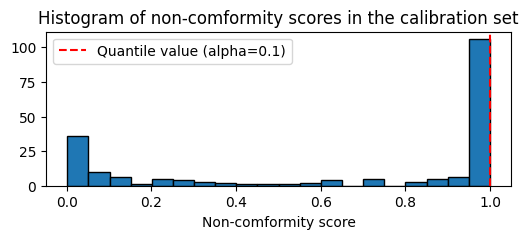

A good predictor should have low non-comformity scores, concentrated at the left side of the figure


In [10]:
import matplotlib.pyplot as plt

# plot histogram and quantile
plt.figure(figsize=(6, 2))
plt.hist(score_per_group, edgecolor='k', linewidth=1, bins=20)
plt.axvline(
    x=threshold, linestyle='--', color='r', label='Quantile value (alpha=0.1)'
)
# plt.axvline(
#     x=get_threshold(1-cal_df['true_prob'], alpha=0.1), linestyle='--', color='b', label='Navive Quantile value (alpha=0.1)'
# )
plt.title('Histogram of non-comformity scores in the calibration set')
plt.xlabel('Non-comformity score')
plt.legend()
plt.show()
print('A good predictor should have low non-comformity scores, concentrated at the left side of the figure')

Evaluation on Cal Set
Avg task accuracy: 0.7458
Avg annotation accuracy: 0.3433


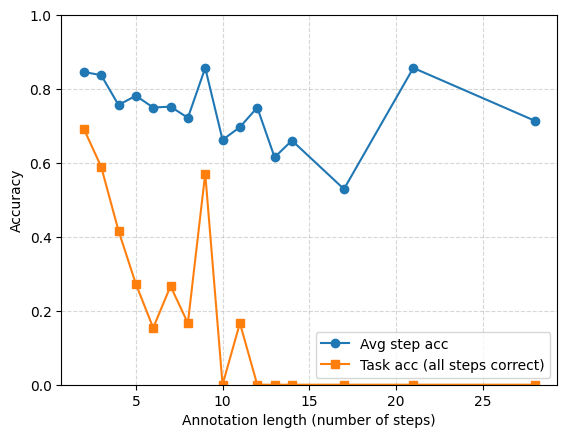

In [14]:
print("Evaluation on Cal Set")
print(f"Avg task accuracy: {cal_df['correct'].mean():.4f}")
print(f"Avg annotation accuracy: {grouped['correct'].min().mean():.4f}")
_ = utils.plot.accuracy_vs_length(cal_df)

In [19]:
import numpy as np
import pandas as pd

def _token_f1(pred: str, label: str) -> float:
    p = set(pred.strip().split())
    l = set(label.strip().split())
    if not p and not l:
        return 1.0
    if not p or not l:
        return 0.0
    tp = len(p & l)
    fp = len(p - l)
    fn = len(l - p)
    prec = tp / (tp + fp) if (tp + fp) else 0.0
    rec = tp / (tp + fn) if (tp + fn) else 0.0
    return 0.0 if (prec == 0 or rec == 0) else 2 * prec * rec / (prec + rec)

def evaluate_results_df(results_df: pd.DataFrame) -> dict:
    # Element accuracy: mean of the “correct” flag (generated == label)
    element_acc = results_df["correct"].mean()

    # Operation F1: token-level F1 between generated and label_text
    op_f1 = np.mean([
        _token_f1(str(g), str(l))
        for g, l in zip(results_df["pred_label"], results_df["label_text"])
    ])

    # Step SR (macro across tasks): average of mean correctness per annotation_id
    per_ann_correct = results_df.groupby("annotation_id")["correct"].mean()
    step_sr = per_ann_correct.mean()

    # Task SR (all steps correct within an annotation_id)
    task_sr = (results_df.groupby("annotation_id")["correct"].all()).mean()

    return {
        "element_acc": round(element_acc,2),
        "op_f1": round(op_f1,2),
        "step_sr": round(step_sr,2),
        "task_sr": round(task_sr,2),
    }

print("Evaluation on Cal Set")
print("Overall Metrics:")
print(evaluate_results_df(cal_df))

for idx_split, split_name in idx_split_map.items():
    print(f"Metrics for split: {split_name}")
    split_df = cal_df[cal_df["test_split"] == idx_split]
    print(evaluate_results_df(split_df))


Evaluation on Cal Set
Overall Metrics:
{'element_acc': np.float64(0.75), 'op_f1': np.float64(0.0), 'step_sr': np.float64(0.77), 'task_sr': np.float64(0.34)}
Metrics for split: test_task
{'element_acc': np.float64(0.87), 'op_f1': np.float64(0.0), 'step_sr': np.float64(0.87), 'task_sr': np.float64(0.46)}
Metrics for split: test_domain
{'element_acc': np.float64(0.71), 'op_f1': np.float64(0.0), 'step_sr': np.float64(0.75), 'task_sr': np.float64(0.33)}
Metrics for split: test_website
{'element_acc': np.float64(0.73), 'op_f1': np.float64(0.0), 'step_sr': np.float64(0.75), 'task_sr': np.float64(0.25)}


In [26]:
x=cal_df[cal_df["correct"] == 0].loc[:, ["annotation_id", "true_prob", "generated", "label", "choices_probs"]]
print(x["generated"].value_counts())
print(x["label"].value_counts())

generated
A    160
D      5
B      2
F      1
E      1
Name: count, dtype: int64
label
B    143
F     25
A      1
Name: count, dtype: int64


In [90]:
# test_df = run_evaluation(test_dict.values(), max_iter=10)
# test_df.to_pickle("test_results.pkl")
test_df = pd.read_pickle("test_results.pkl")

test_df['correct'] = test_df['generated'] == test_df['label']
test_df['pred_set'] = test_df['choices_probs'].apply(lambda row: [ label for label, prob in row.items() if 1 - prob <= threshold])
test_df['pred_set_size'] = test_df['pred_set'].apply(len)
test_task_group = test_df.groupby('annotation_id')
test_df.head()

,index,annotation_id,action_uid,generated,label,label_text,choices_probs,prob,correct,pred_set,pred_set_size
0,1,277e3468-f8cb-45c6-9e4b-0328066c42d3,6584ac66-77f3-4b4f-878f-604d8c93ba48,A,B,B.\nAction: CLICK,"{'A': 0.9994745850563049, 'B': 2.4702232622075...",0.999475,False,[A],1
1,2,277e3468-f8cb-45c6-9e4b-0328066c42d3,d2f1a65e-ba3a-4aaf-9b6f-118069f32444,A,B,B.\nAction: CLICK,"{'A': 0.8732188940048218, 'B': 0.1246431320905...",0.873219,False,"[A, B, C, D, E, F]",6
2,3,277e3468-f8cb-45c6-9e4b-0328066c42d3,bd937d20-eae1-4028-958b-be2d2a0dd9b8,F,F,F.\nAction: TYPE\nValue: 60505,"{'A': 0.0017695568967610598, 'B': 1.1124548109...",0.998094,True,"[A, F]",2
3,4,277e3468-f8cb-45c6-9e4b-0328066c42d3,d078a194-660a-41bc-bacd-12abc3ad9fd5,A,F,F.\nAction: CLICK,"{'A': 0.9992172718048096, 'B': 9.2066329671069...",0.999217,False,"[A, F]",2
4,5,277e3468-f8cb-45c6-9e4b-0328066c42d3,29fccaeb-9af1-4e6a-acd3-bc89ff58eb3b,B,B,B.\nAction: CLICK,"{'A': 0.07011602073907852, 'B': 0.743930518627...",0.743931,True,"[A, B, C, D, E, F]",6


Evaluation on Test Set
Avg task accuracy: 0.6667
Avg annotation accuracy: 0.2500


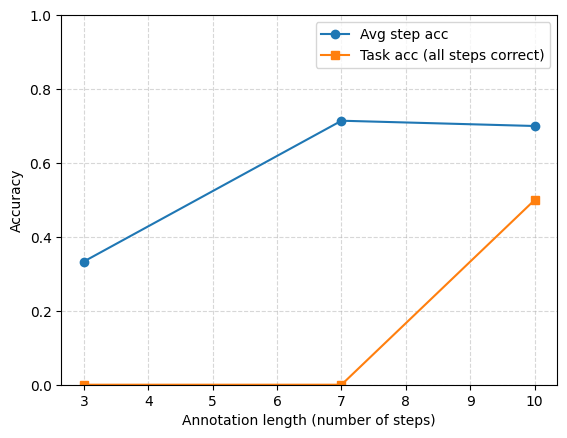

,length,step_acc_mean,task_acc_mean,n_annotations
0,3,0.333333,0.0,1
1,7,0.714286,0.0,1
2,10,0.700000,0.5,2


In [101]:
print("Evaluation on Test Set")
print(f"Avg task accuracy: {test_df['correct'].mean():.4f}")
print(f"Avg annotation accuracy: {test_task_group['correct'].min().mean():.4f}")
utils.plot_accuracy_vs_length(test_df)


In [100]:
len(grouped)


54

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

from mind2web.dataloader import MultiChoiceDataset, get_data_split
from mind2web.evaluate import FastActionEvaluatorMultiChoice  # note the file name
# if installed as a package, you can also do: from mind2web.evauate import FastActionEvaluatorMultiChoice

# Load tokenizer/model
# model_name = "osunlp/MindAct_ActionPrediction_flan-t5-xl"
# model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda")

# Prepare data (adjust paths/splits as needed)
# data_dir = "osunlp/Multimodal-Mind2Web"
# split_file = "test_task"  # example split
# data = get_data_split(data_dir, split_file)
# dataset = MultiChoiceDataset(data, tokenizer, num_candidates=5, max_context_len=512, mode="multichoice")

# Run evaluation
evaluator = FastActionEvaluatorMultiChoice(tokenizer, max_context_len=512)
result = evaluator.evaluate_dataset(
    test_dict["test_task"],  # dataset to evaluate
    model,
    batch_size=8,
    top_k=50,
    output_path='./results',  # set a folder path to save JSON outputs
    name="test_task",
    template=None,     # optionally a tuple (prefix_context, suffix_input)
    max_new_tokens=50,
)

print(result)


/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (125915272 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import sys
import importlib

sys.path.append('./Mind2Web/src') 

# Force reload the metric module
if 'action_prediction.metric' in sys.modules:
    importlib.reload(sys.modules['action_prediction.metric'])

from action_prediction.metric import ActionEvaluatorGeneration, ActionEvaluatorMultiChoice

evaluator = ActionEvaluatorMultiChoice(tokenizer)
test_dataset = dataset
test_key = "task"
output_path = os.getcwd()
result = evaluator.evaluate_dataset(
    test_dataset,
    model,
    output_path=output_path,
    name=test_key,
    template=None, #lm_template,
    top_k=50#cfg.top_k,)
)


 12%|█▏        | 158/1339 [48:58<6:06:01, 18.60s/it, action_f1=0, element_acc=0]



KeyboardInterrupt: 

In [ ]:
# df = pd.DataFrame(test_task_ds)
# len(df.groupby("annotation_id"))
# subsample[0]['action_reprs']

# test_domain_ds = ds['test_domain']
# test_task_ds = ds['test_task']
# test_website_ds = ds['test_website']
count = 0
missing_count = 0
mulit = {}
missing = {}
for i, x in enumerate(test_task_ds):
    if len(x['pos_candidates']) > 1:
        count += 1
        mulit[i] = x['annotation_id']
    if len(x['pos_candidates']) == 0:
        # print('Missing pos_candidates:', x['annotation_id'])
        missing_count += 1
        missing[i] = x['annotation_id']

print("Number of samples with multiple positive candidates in test_website:", count)
print("Number of samples with missing positive candidates in test_website:", missing_count)

In [ ]:

import argparse
import json
import pathlib
import sys
from typing import Any, Dict

import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Import the repository's dataset utilities
from action_prediction.dataloader import MultiChoiceDataset, get_data_split  # type: ignore





def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--model-name", default="google/flan-t5-base")
    parser.add_argument("--data-dir", required=True, help="data dir or dataset script used by get_data_split")
    parser.add_argument("--split-file", required=True, help="path to split json file or list accepted by get_data_split")
    parser.add_argument("--num-samples", type=int, default=10)
    parser.add_argument("--device", default="cuda" if torch.cuda.is_available() else "cpu")
    parser.add_argument("--out", default="multichoice_generations.json")
    parser.add_argument("--max-new-tokens", type=int, default=50)
    args = parser.parse_args()

    outputs = generate_with_dataset(
        model_name=args.model_name,
        data_dir=args.data_dir,
        split_file=args.split_file,
        num_samples=args.num_samples,
        device=args.device,
        max_new_tokens=args.max_new_tokens,
    )

    with open(args.out, "w") as f:
        json.dump(outputs, f, indent=2)
    print(f"Wrote {len(outputs)} generations to {args.out}")


if __name__ == "__main__":
    main()

In [4]:
# Group by annotation_id (this creates a GroupBy object for fast access)
grouped = df.groupby('annotation_id')

# Retrieve all rows for a specific annotation_id
ann_id = train_ds[0]["annotation_id"]
task_df = grouped.get_group(ann_id).sort_values('target_action_index')

print(f"Task: {task_df.iloc[0]['confirmed_task']}")
# Iterate and display (task_df is a DataFrame)
for _, ex in task_df.iterrows():
    print(
        f"step={int(ex['target_action_index']) + 1}/{len(task_df)} | op={ex['operation']} "
        f"| target_action={ex["target_action_reprs"]} | pos_candidates={len(ex['pos_candidates'])}, action_id={ex['action_id']}"
    )
    # display(train_ds[ex["action_id"]]["screenshot"])

Task: rent a car in Brooklyn - Central, NY on from April 9 to April 15.
step=1/7 | op={"original_op": "CLICK", "value": "", "op": "CLICK"} | target_action=[heading]  CAR -> CLICK | pos_candidates=1, action_id=0
step=2/7 | op={"original_op": "TYPE", "value": "Brooklyn Central", "op": "TYPE"} | target_action=[combobox]  Enter pick up city, airport name, or airport code. -> TYPE: Brooklyn Central | pos_candidates=1, action_id=1
step=3/7 | op={"original_op": "CLICK", "value": "", "op": "CLICK"} | target_action=[div]  Brooklyn - Central (New York), US -> CLICK | pos_candidates=1, action_id=2
step=4/7 | op={"original_op": "CLICK", "value": "", "op": "CLICK"} | target_action=[textbox]  Pickup -> CLICK | pos_candidates=1, action_id=3
step=5/7 | op={"original_op": "CLICK", "value": "", "op": "CLICK"} | target_action=[button]  Sunday, April 9, 2023 -> CLICK | pos_candidates=1, action_id=4
step=6/7 | op={"original_op": "CLICK", "value": "", "op": "CLICK"} | target_action=[button]  Saturday, April

In [12]:
import torch
import sys
import os

# Add Mind2Web to path so we can import from it
sys.path.append('./Mind2Web/src')

from candidate_generation.dataloader import CandidateRankDataset, get_data_split
from candidate_generation.metric import CERerankingEvaluator
from candidate_generation.model import CrossEncoder
from torch.utils.data import DataLoader

eval_data = train_ds
batch_size = 350
max_seq_length = 512

eval_evaluator = CERerankingEvaluator(
    eval_data,
    k=50,
    max_neg=-1,
    batch_size=batch_size,
    name="train",
)

# Use the model path for the CrossEncoder (like in evaluate.py)
model_path = "osunlp/MindAct_CandidateGeneration_deberta-v3-base"
model = CrossEncoder(
    model_path,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    num_labels=1,
    max_length=max_seq_length,
)

# Evaluate the model
print("Running evaluation...")
eval_evaluator(model, output_path="./output")
print("Evaluation completed!")
print("Results saved to: ./output")

ModuleNotFoundError: No module named 'dataloader'

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Download the MindAct Candidate Generation model
print("Downloading MindAct Candidate Generation model...")
model_name = "osunlp/MindAct_CandidateGeneration_deberta-v3-base"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=CACHE_DIR)

# Load model
candidate_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    cache_dir=CACHE_DIR,
    torch_dtype=torch.float16,  # Use float16 for efficiency
    device_map="auto"  # Automatically handle device placement
)

print(f"Model {model_name} downloaded and loaded successfully!")
print(f"Model type: {type(candidate_model)}")
print(f"Number of parameters: {sum(p.numel() for p in candidate_model.parameters()):,}")